# Import Libraries

In [35]:
# Core
import numpy as np
import pandas as pd
from pathlib import Path
import warnings, logging, math, json, gc
from typing import List, Dict, Tuple

# Visualization
import matplotlib.pyplot as plt

# ML & preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Utilities
from tqdm.auto import tqdm


# Import Dataset from Kaggle

In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/khanhvyho/.cache/kagglehub/datasets/rounakbanik/the-movies-dataset/versions/7


In [37]:
from pathlib import Path

DATA_DIR = Path(path)  
movies = pd.read_csv(DATA_DIR / "movies_metadata.csv") # dataset 1: movies
ratings = pd.read_csv(DATA_DIR / "ratings.csv")        # dataset 2: ratings


/var/folders/4q/f7mc1yk54dl9_0pq9f41x_840000gn/T/ipykernel_27049/3712168527.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(DATA_DIR / "movies_metadata.csv") # dataset 1: movies


# Data Wrangling and Exploration

## Step 1: Clean the "movies" dataset
In the movies dataset, the "genres" column is the variable of interest. Each movie can belong to more than one genre - for example, Toy Story (1995) is classified under Animation, Comedy, and Family. 
- The genre values are not clean now; for example, Toy Story's genre appears as "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]". 
- Our goal in this step is to extract and clean them into the format [Animation, Comedy, Family].

In [38]:
import pandas as pd, ast

# Clean "genres" column
def to_genre_names(x):
    if pd.isna(x) or x == "" or x == "[]":
        return []
    # If it's a string like "[{'id': 35, 'name': 'Comedy'}, ...]" → parse it
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            return []
    # Now x should be a list of dicts; keep only names
    return [d.get("name") for d in x if isinstance(d, dict) and d.get("name")]

movies["genre_names"] = movies["genres"].apply(to_genre_names)

In [39]:
print(movies["genre_names"].head())

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genre_names, dtype: object


In [40]:
# Explodes the genre_names lists to rows, drops resulting NaNs only in that temporary Series, and returns the sorted set of unique genres without changing the original DataFrame
unique_genres = sorted(movies["genre_names"].explode().dropna().unique())
print("There are:", len(unique_genres), "unique genres.")
print(unique_genres)


There are: 32 unique genres.
['Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Romance', 'Science Fiction', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'The Cartel', 'Thriller', 'Vision View Entertainment', 'War', 'Western']


After examining the unique genres, 12 out of 32 were identified as invalid entries — for example, “Mardock Scramble Production Committee” or “Odyssey Media.”
Strategy: Determine how many observations contain these invalid genres.
- If the number is small, drop them.
- If the number is large, conduct further investigation before deciding.

In [41]:
import pandas as pd
import re
import ast

valid_genres = ["Action","Adventure","Animation","Comedy","Crime","Documentary","Drama","Family",
    "Fantasy","Foreign","History","Horror","Music","Mystery","Romance","Science Fiction",
    "TV Movie","Thriller","War","Western"]

VALID = set(valid_genres)

In [42]:
def normalize(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

def to_list_of_names(x):
    """Return a list[str] of genre names from x (list/dict/string/None)."""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, list):
        out = []
        for e in x:
            if isinstance(e, dict) and "name" in e:
                out.append(normalize(e["name"]))
            else:
                out.append(normalize(e))
        return out
    if isinstance(x, str):
        # try to parse strings like "[{'id':..., 'name':'Comedy'}, ...]" or "['Drama','Comedy']"
        try:
            parsed = ast.literal_eval(x)
            return to_list_of_names(parsed)
        except Exception:
            return [normalize(x)]
    return [normalize(x)]

movies["genre_names"] = movies["genre_names"].apply(to_list_of_names)


In [43]:
unique_genres = sorted({g for lst in movies["genre_names"] for g in lst})
print("Unique labels found:", unique_genres)
print("Invalid labels (vs your valid 20):", sorted(set(unique_genres) - VALID))


Unique labels found: ['Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Romance', 'Science Fiction', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'The Cartel', 'Thriller', 'Vision View Entertainment', 'War', 'Western']
Invalid labels (vs your valid 20): ['Aniplex', 'BROSTA TV', 'Carousel Productions', 'GoHands', 'Mardock Scramble Production Committee', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Sentai Filmworks', 'Telescene Film Group Productions', 'The Cartel', 'Vision View Entertainment']


In [44]:
# Flag rows within dataset that have invalid genres
has_invalid = movies["genre_names"].apply(lambda lst: any(g not in VALID for g in lst))
has_invalid.value_counts(dropna=False)


genre_names
False    45463
True         3
Name: count, dtype: int64

Fortunately, there are only 3 rows/observations contain invalid genres. Therefore, dropping these 3.

In [45]:
# Drop rows that has invalid genres
movies_clean = movies.loc[~has_invalid].copy()
print(f"Dropped {int(has_invalid.sum())} rows; kept {len(movies_clean)} rows.")


Dropped 3 rows; kept 45463 rows.


In [46]:
# Drop rows with empty genre lists
movies_clean = movies_clean.loc[movies_clean["genre_names"].map(len) > 0].copy()
print(f"After removing empties: {len(movies_clean)} rows.")

After removing empties: 43021 rows.


## Step 2: One-hot encoding

After cleaning invalid entries, we need to convert the list of genres (e.g., [Animation, Comedy, Family]) into a numerical format that can be used for clustering or machine learning models.
- What is one-hot encoding? One-hot encoding transforms categorical values (like genre names) into binary indicator columns.
- In this case, each genre becomes its own column, where: 1 indicates the movie belongs to that genre, and 0 indicates it does not. Example below:

    | Movie Title | Animation | Comedy | Family |
    |-------------|:---------:|:------:|:------:|
    | *Toy Story* (1995) | 1 | 1 | 1 |

In [47]:
# Drop invalid genre columns if any exist
label_set = set(unique_genres)   
movies_clean = movies_clean.drop(columns=list(label_set), errors="ignore")

# One-hot encode with 20 valid genres
s = movies_clean["genre_names"].explode()
dummies = (
    pd.crosstab(s.index, s)
      .clip(upper=1)
      .reindex(columns=valid_genres, fill_value=0)
      .astype("int8")
      .reindex(index=movies_clean.index, fill_value=0)
)

# Attach the clean dummies
movies_clean = movies_clean.join(dummies)

# Double-check to ensure no invalid genre columns remain
assert not any(col in movies_clean.columns for col in (label_set - set(valid_genres)))

# Export
movies_clean.to_csv("movies_with_genres_onehot.csv", index=False)

## Step 3: Merge 2 datasets

At this step, we join the "movies_clean" and "ratings" datasets using an inner join to keep only rows with matching movie IDs.

In [48]:
movies_clean["id"] = pd.to_numeric(movies_clean["id"], errors="coerce").astype("Int64")
movies_clean["id"].dtype

movies_ratings = ratings.merge(movies_clean, left_on="movieId", right_on="id", how="inner")

In [49]:
len(movies_ratings)

11382421

There are about 11.3 million individual rating records (each row = one user rating for one movie) in "movies_ratings" dataset.

In [50]:
movies_ratings.to_csv("movies_ratings.csv", index=False)

In [51]:
movies_ratings.head(200).to_csv("movies_ratings_sample.csv", index=False)

In [52]:
movies_ratings["userId"].nunique() #There are 265848 users we will analyze

265848

There are about 266K users unique/distinct users in "movies_rating" dataset.

In [53]:
dataset = movies_ratings.filter(items=["userId","movieId","rating","original_title", "genre_names",
                                       "Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary", "Drama", "Family", "Fantasy", "Foreign",
                                       "History", "Horror", "Music", "Mystery", "Romance", "Science Fiction", "TV Movie", "Thriller", "War", "Western"]).copy()
dataset.head(200).to_csv("audience_dataset.csv", index=False)

# Feature Engineering

## Step 1: Aggregate user-level features - Counts and Average Ratings per Genre

To represent each user’s viewing behavior and taste, two sets of features (Count and Average Rating) are created from the merged "movies–ratings" dataset:  
1.  **Count**
    - Measures how much a user engages with each genre.
    - For every genre, the count feature (cnt_<Genre>) captures the number of titles the user has rated within that genre.  
    - Example: A user with cnt_Drama = 14 and cnt_Comedy = 7 has rated 14 drama titles and 7 comedies.  
2. **Average Rating**
    - Measures how positively a user responds to each genre.  
    - The average rating feature (avg_<Genre>) is calculated as the mean rating a user gives to all movies in that genre.  
    - Example: avg_Drama = 4.1 suggests that the user tends to enjoy dramas more than other genres.  

In [54]:
df = dataset.copy()
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# If there can be duplicate ratings per (userId, movieId), de-dupe (optional):
# df = df.drop_duplicates(subset=["userId","movieId"], keep="last")

valid_genres = [
    "Action","Adventure","Animation","Comedy","Crime","Documentary","Drama","Family",
    "Fantasy","Foreign","History","Horror","Music","Mystery","Romance",
    "Science Fiction","TV Movie","Thriller","War","Western"
]
genres = [g for g in valid_genres if g in df.columns]

# Total movies rated per user
total = df.groupby("userId").size().rename("total_ratings")

# Counts per genre (sum of 0/1 dummies)
cnt = df.groupby("userId")[genres].sum().astype("int32")
cnt.columns = [f"cnt_{g}" for g in genres]

# Average rating per genre = sum(rating * 1{genre}) / count
sum_rating = df[genres].multiply(df["rating"], axis=0).groupby(df["userId"]).sum()
avg_vals = np.divide(
    sum_rating.values,
    cnt.values,
    out=np.zeros_like(sum_rating.values, dtype=float),
    where=cnt.values > 0
)
avg = pd.DataFrame(avg_vals, index=sum_rating.index, columns=[f"avg_{g}" for g in genres])

# Final user table
user_genre_stats = pd.concat([total, cnt, avg], axis=1).reset_index()

# Export file
user_genre_stats.to_csv("user_genre_stats.csv", index=False)


In [55]:
user_genre_stats.describe().to_csv("user_genre_stats_summary.csv")

In [56]:
user_df = user_genre_stats.copy()

## Step 2: Feature Standardization

After constructing user-level features (genre counts and average ratings), the next step is to standardize them so they are comparable in scale. This ensures that models like K-Means, which rely on Euclidean distance, are not biased toward features with larger numerical ranges.<br>
Example: Count features (cnt_<Genre>) can range from 0 to hundreds, while Average rating features (avg_<Genre>) typically range from 0 to 5. Therefore, without scaling, the clustering algorithm would prioritize count features simply because of their magnitude.

In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1) Pick features (paired cnt_/avg_ per genre)
cnt_cols = [c for c in user_df.columns if c.startswith("cnt_")]
avg_cols = [c for c in user_df.columns if c.startswith("avg_")]
genres = [c[4:] for c in cnt_cols if f"avg_{c[4:]}" in user_df.columns]
cnt_cols = [f"cnt_{g}" for g in genres]
avg_cols = [f"avg_{g}" for g in genres]

# 2) Build features (separate columns for counts & avgs)
X = user_df[cnt_cols + avg_cols].copy()
X[cnt_cols] = X[cnt_cols].fillna(0).astype(float)
X[avg_cols] = X[avg_cols].fillna(0).astype(float)

scaler = StandardScaler()
Xs = scaler.fit_transform(X.values)

In [58]:
print(X[cnt_cols])

        cnt_Action  cnt_Adventure  cnt_Animation  cnt_Comedy  cnt_Crime  \
0              1.0            0.0            0.0         4.0        1.0   
1              4.0            4.0            0.0         5.0        1.0   
2              2.0            0.0            0.0         5.0        3.0   
3              4.0            3.0            0.0         7.0        4.0   
4              3.0            1.0            0.0         2.0        2.0   
...            ...            ...            ...         ...        ...   
265843         7.0            6.0            0.0        17.0        6.0   
265844        11.0           18.0            2.0        23.0       12.0   
265845        10.0            7.0            1.0        18.0       11.0   
265846         2.0            1.0            0.0         6.0        4.0   
265847        22.0           17.0            1.0        40.0       21.0   

        cnt_Documentary  cnt_Drama  cnt_Family  cnt_Fantasy  cnt_Foreign  \
0                   1.0

# Modeling

## Step 1: Determine the optimal number of clusters (k)

After preparing standardized user features, the next step is to determine the optimal number of clusters (k) for K-Means. Choosing the right k ensures that the clusters are both distinct and meaningful - not too few (overly broad) or too many (overfitting small differences). To evaluate possible values of k, four complementary methods were applied:  

1. Elbow Method
2. Silhouette Score
3. Calinski–Harabasz Index
4. Davies–Bouldin Index

| Metric                                      | Ideal Direction | Description                                                                                                |
| :------------------------------------------ | :-------------- | :--------------------------------------------------------------------------------------------------------- |
| **Elbow Method (Inertia / SSE)**            | Lower → Better (look for "elbow") | Plots within-cluster variance vs. *k*; the “elbow” point indicates where adding more clusters yields diminishing returns. |
| **Silhouette Score (sil)**                  | Higher → Better | Measures how well each sample fits within its cluster vs. other clusters (range: –1 to 1).                 |
| **Calinski–Harabasz Index (ch)**            | Higher → Better | Ratio of between-cluster dispersion to within-cluster dispersion; higher means clearer cluster separation. |
| **Davies–Bouldin Index (db)**               | Lower → Better  | Average similarity between each cluster and its most similar one; lower means more distinct clusters.      |
| **Cluster Size Range (size_min, size_max)** | Balanced        | Helps detect uneven or unstable clustering.                                                                |


Inertias (SSE) by k: {2: np.float64(7649650.94), 3: np.float64(6220943.53), 4: np.float64(5443196.26), 5: np.float64(4994232.38), 6: np.float64(4713619.55), 7: np.float64(4522126.62), 8: np.float64(4373947.63), 9: np.float64(4239753.93), 10: np.float64(4136356.38)}
Suggested k (elbow): 5


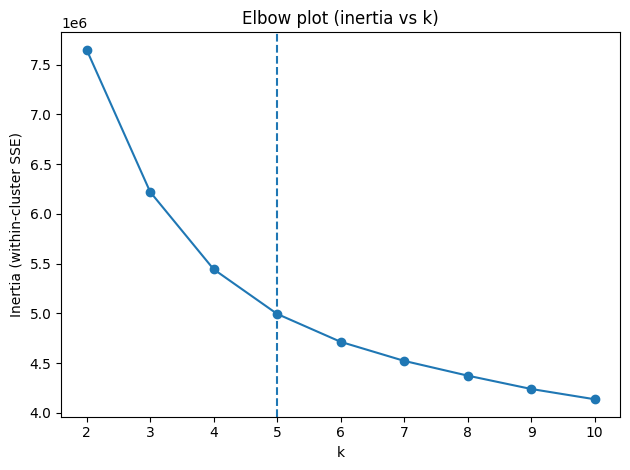

In [59]:
# 1. Elbow Method

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans

# --- Elbow on your standardized features Xs ---
use_minibatch = False  # set True for speed on very large data
Clusterer = MiniBatchKMeans if use_minibatch else KMeans

k_values = list(range(2, 11))
inertias = []
for k in k_values:
    if use_minibatch:
        km = Clusterer(n_clusters=k, n_init=5, random_state=0, batch_size=4096, max_iter=100)
    else:
        km = Clusterer(n_clusters=k, n_init=10, random_state=0, algorithm="elkan")
    km.fit(Xs)
    inertias.append(km.inertia_)

# --- Knee (elbow) detection by max distance to the line between endpoints ---
ks = np.array(k_values, dtype=float)
sse = np.array(inertias, dtype=float)
ks_n  = (ks  - ks.min())  / (ks.max()  - ks.min())
sse_n = (sse - sse.min()) / (sse.max() - sse.min())
p1, p2 = np.array([ks_n[0], sse_n[0]]), np.array([ks_n[-1], sse_n[-1]])
line = p2 - p1
norm = np.array([-line[1], line[0]])
dists = np.abs((ks_n - p1[0]) * norm[0] + (sse_n - p1[1]) * norm[1]) / np.linalg.norm(norm)
k_star = int(ks[np.argmax(dists)])

print("Inertias (SSE) by k:", dict(zip(k_values, np.round(inertias, 2))))
print("Suggested k (elbow):", k_star)

# --- Plot ---
plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.axvline(k_star, linestyle="--")
plt.title("Elbow plot (inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia (within-cluster SSE)")
plt.tight_layout()
plt.show()

**Interpretation:**

The elbow plot above shows a sharp decrease in within-cluster SSE (inertia) from k = 2 to k = 5, after which the improvement begins to flatten.

- From k = 2 → 5, inertia drops significantly (from ~7.6M to ~5.0M).

- Beyond k = 5, the reduction in SSE becomes marginal, indicating diminishing returns from adding more clusters.

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

Ks = range(2,9)
metrics = {}
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    lab = km.fit_predict(Xs)  # Xs = your standardized features (counts+avgs)
    metrics[k] = {
        "sil": silhouette_score(Xs, lab, sample_size=min(10000, len(lab)), random_state=0),
        "ch":  calinski_harabasz_score(Xs, lab),
        "db":  davies_bouldin_score(Xs, lab),
        "size_min": np.bincount(lab).min(),
        "size_max": np.bincount(lab).max(),
    }
metrics

{2: {'sil': 0.49720716772880186,
  'ch': 103711.44486051596,
  'db': 0.9624116287377927,
  'size_min': np.int64(21147),
  'size_max': np.int64(244701)},
 3: {'sil': 0.20848178875206072,
  'ch': 94291.83846222823,
  'db': 1.4243130238926387,
  'size_min': np.int64(10278),
  'size_max': np.int64(146503)},
 4: {'sil': 0.18645522507165233,
  'ch': 84504.45414623832,
  'db': 1.4472461144449076,
  'size_min': np.int64(4248),
  'size_max': np.int64(131864)},
 5: {'sil': 0.1570066672392881,
  'ch': 75050.17258035438,
  'db': 1.5459421374264533,
  'size_min': np.int64(2332),
  'size_max': np.int64(114460)},
 6: {'sil': 0.14153168773782004,
  'ch': 66779.47070426248,
  'db': 1.5617105630232837,
  'size_min': np.int64(609),
  'size_max': np.int64(102191)},
 7: {'sil': 0.1182427293673773,
  'ch': 59882.09300801461,
  'db': 1.7597550385653586,
  'size_min': np.int64(417),
  'size_max': np.int64(81536)},
 8: {'sil': 0.11362631900078704,
  'ch': 54352.75817434583,
  'db': 1.8073573948602921,
  'size_

|  k  | Silhouette ↑ |     CH ↑    |   DB ↓   | Comment                                  |
| :-: | :----------: | :---------: | :------: | :--------------------------------------- |
|  2  |   **0.497**  | **103,711** | **0.96** | Strong separation and compact clusters   |
|  3  |     0.208    |    94,292   |   1.42   | Weaker structure                         |
|  4  |     0.186    |    84,504   |   1.45   | Further decline in quality               |
|  5  |     0.157    |    75,050   |   1.55   | No significant improvement               |
| 6–8 |     <0.15    |   <67,000   |   >1.56  | Increasing fragmentation and instability |

**Interpretation:**

- The silhouette score drops sharply after k = 2, indicating poorer separation as the number of clusters increases.

- CH index steadily decreases beyond k = 2, suggesting reduced between-cluster distinctiveness.

- DB index rises beyond k = 2, showing increasing overlap between clusters.

- Cluster sizes also become highly uneven as k grows (e.g., smallest cluster shrinks from ~21K at k=2 to only ~450 at k=8).

## Final selection: k = 2
To determine the optimal number of clusters (k), both the Elbow Method and multiple internal validation metrics were applied. The elbow plot initially suggested k = 5 based on the point of diminishing returns in inertia (within-cluster SSE). 

However, further evaluation using Silhouette, Calinski–Harabasz, and Davies–Bouldin scores indicated that the clustering quality is highest at k = 2. Specifically, k = 2 achieved the highest silhouette (0.497), highest CH index (103,711), and lowest DB index (0.96), suggesting the most compact and well-separated clusters. In contrast, higher k values resulted in smaller, less stable clusters with weaker separation.

Therefore, despite the elbow method’s geometric indication at k = 5, the combined evidence from internal validation supports k = 2 as the most reliable and interpretable clustering structure for this dataset.

# K-Mean Clustering and Principal Component Analysis for Visualization

1. **K-Means Clustering**

K-Means clustering is an unsupervised learning algorithm that groups data points into k clusters based on similarity in their numerical features. It works by iteratively assigning each observation to the nearest cluster centroid and updating those centroids to minimize within-cluster variance. In this project, K-Means is applied to segment users by counts and average ratings by genres.

- Purpose is to identify natural audience segments without predefined labels.

- Each cluster represents a group of users who share similar viewing intensity and content taste.

- Setting k=2 allows us to distinguish between regular watchers (lower counts, higher ratings) and power users (higher counts, lower ratings).

2. **PCA for Visualization**

In this analysis, PCA is used only for visualization, not for clustering.

- It reduces the many input features to two components (PC1 and PC2) so the clusters can be plotted in 2D space.

- PC1 often reflects overall viewing volume or engagement level, while PC2 captures secondary differences such as rating patterns or genre preferences.


**PC1** (Volume): separates users by watching frequency, which dominates total variance in behavior.

PC1 (49.4% variance) captures overall viewing volume across genres. The top contributing features (cnt_Drama, cnt_Comedy, cnt_Action, cnt_Thriller, and cnt_Romance) all represent view counts, suggesting PC1 reflects how much content a user watches overall, regardless of genre.  **Users with higher PC1 scores are heavier watchers who consume more titles in nearly every genre.**

**PC2** (Ratings): adds nuance by reflecting differences in genre-specific satisfaction.

PC2 (12.9% variance) captures average rating behavior across genres. The strongest contributors (avg_Action, avg_Adventure, avg_Science Fiction, avg_Thriller, and avg_Crime) are average ratings, indicating PC2 represents how users rate content. **Higher PC2 scores may correspond to users who rate these genres more favorably, while lower scores may reflect users who are more critical or less engaged.**


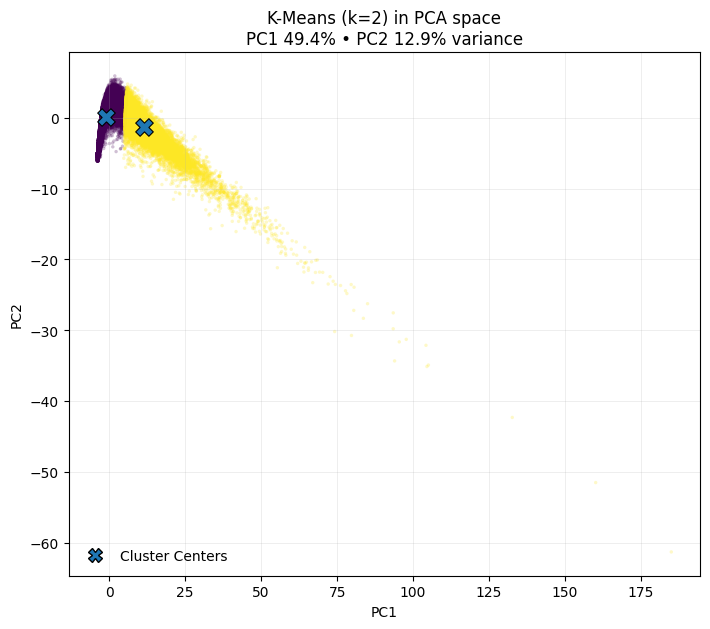

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# 1) Fit K-Means on standardized features ---
km = KMeans(n_clusters=2, n_init=10, random_state=0, algorithm="elkan").fit(Xs)
labels = km.labels_

# 2) PCA for visualization only ---
pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(Xs)
centers_2d = pca.transform(km.cluster_centers_)
var = pca.explained_variance_ratio_       # [pc1, pc2]

# 3) Balanced subsample so minority cluster is visible ---
rng = np.random.default_rng(0)
idxs = []
n_per = 40000  # tweak for speed/clarity
for k in np.unique(labels):
    k_idx = np.where(labels == k)[0]
    take = min(n_per, len(k_idx))
    idxs.append(rng.choice(k_idx, size=take, replace=False))
idx = np.concatenate(idxs)

# 4) Plot
plt.figure(figsize=(7.2, 6.4))
scatter = plt.scatter(
    XY[idx, 0], XY[idx, 1],
    c=labels[idx], s=6, alpha=0.25, linewidths=0, rasterized=True
)

plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1],
    s=160, marker="X", edgecolor="black", linewidths=0.8, zorder=3
)

plt.title(f"K-Means (k=2) in PCA space\nPC1 {var[0]*100:.1f}% • PC2 {var[1]*100:.1f}% variance")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.25, linewidth=0.6)

# Custom legend
handles = [
    Line2D([0], [0], marker='X', linestyle='None', label='Cluster Centers', markersize=10, markeredgecolor='black')
]
plt.legend(handles=handles, frameon=False, loc="lower left")

plt.tight_layout()
plt.show()

In [63]:
import numpy as np

# feature names must match the columns order in Xs_balanced: [cnt_cols, avg_cols]
feat_names = list(cnt_cols) + list(avg_cols)
assert len(feat_names) == pca.components_.shape[1], "Names must match PCA feature count."

loadings = pca.components_
var_pct = pca.explained_variance_ratio_ * 100
feat_names = list(cnt_cols) + list(avg_cols)
assert len(feat_names) == loadings.shape[1]

for i in range(2):
    comp = loadings[i]
    top_idx = np.argsort(np.abs(comp))[::-1][:5]
    print(f"\nTop 5 features for PC{i+1} ({var_pct[i]:.2f}% variance):")
    for j in top_idx:
        print(f"  {feat_names[j]}: {comp[j]:+.3f}") 


Top 5 features for PC1 (49.39% variance):
  cnt_Drama: +0.220
  cnt_Comedy: +0.219
  cnt_Action: +0.219
  cnt_Thriller: +0.218
  cnt_Romance: +0.217

Top 5 features for PC2 (12.87% variance):
  avg_Action: +0.278
  avg_Adventure: +0.275
  avg_Science Fiction: +0.271
  avg_Thriller: +0.266
  avg_Crime: +0.263


# Result


The clustering reveals two key audience types **Regular Watchers** (Cluster Purple), who value quality and familiarity, and **Power Users** (Cluster Yellow), who value variety and quantity. Tailoring strategies to both groups can enhance overall user satisfaction and platform engagement.

**Regular Watchers**

1. Who are they? 

- This group represents the core, steady audience base: viewers who engage regularly but not intensively.

2. Behavior:

- Users in this cluster have moderate viewing counts across all major genres (Drama, Comedy, Action, etc.).

- Their average ratings are balanced and slightly higher, suggesting they are generally satisfied with what they choose to watch.

- They tend to watch selectively rather than frequently, indicating more intentional viewing choices.

3. Recommendations: (not done yet)

**Power Users**

1. Who are they? 

- This group explores diverse content and are more likely to notice quality differences or repetitive recommendations.

2. Behavior:

- Users show very high viewing counts across nearly all genres, indicating broad and frequent engagement.

- Their average ratings tend to be lower or more varied, possibly reflecting exposure to mixed-quality content or more critical evaluation habits.

3. Recommendations: (not done yet)

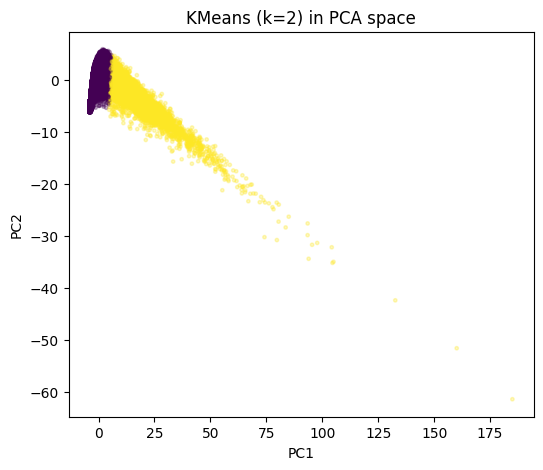

In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(Xs)
labels = kmeans.labels_

pca = PCA(n_components=2, random_state=0)
XY = pca.fit_transform(Xs)

plt.figure(figsize=(6,5)) 
plt.scatter(XY[:,0], XY[:,1], c=labels, s=6, alpha=0.3)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("KMeans (k=2) in PCA space")
plt.show()



Top 5 features for PC1 (49.39% variance):
  cnt_Drama: +0.220
  cnt_Comedy: +0.219
  cnt_Action: +0.219
  cnt_Thriller: +0.218
  cnt_Romance: +0.217

Top 5 features for PC2 (12.87% variance):
  avg_Action: +0.278
  avg_Adventure: +0.275
  avg_Science Fiction: +0.271
  avg_Thriller: +0.266
  avg_Crime: +0.263


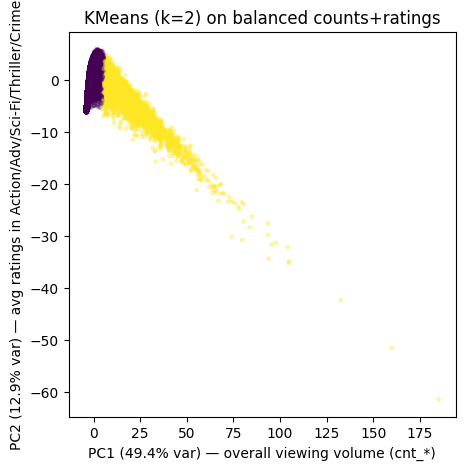

In [30]:
# Rename the plot
plt.figure(figsize=(5,5))
plt.scatter(XY[:,0], XY[:,1], c=labels, s=6, alpha=0.3)
plt.xlabel("PC1 (49.4% var) — overall viewing volume (cnt_*)"); plt.ylabel("PC2 (12.9% var) — avg ratings in Action/Adv/Sci-Fi/Thriller/Crime"); plt.title("KMeans (k=2) on balanced counts+ratings")
plt.show()

In [31]:
genre_means = user_df[cnt_cols].mean().sort_values(ascending=False)
print(genre_means)

cnt_Drama              24.796718
cnt_Comedy             12.216455
cnt_Thriller           10.886318
cnt_Action              8.536382
cnt_Romance             7.917419
cnt_Crime               7.406292
cnt_Adventure           6.022509
cnt_Science Fiction     5.222842
cnt_Mystery             4.402162
cnt_Horror              3.481538
cnt_Fantasy             3.238208
cnt_Family              2.186479
cnt_History             1.697162
cnt_Music               1.519293
cnt_Documentary         1.164824
cnt_Western             0.977386
cnt_Animation           0.916385
cnt_War                 0.913240
cnt_Foreign             0.570710
cnt_TV Movie            0.279333
dtype: float64


In [32]:
rating_means = user_df[avg_cols].mean().sort_values(ascending=False)
print(rating_means)

avg_Drama              3.529138
avg_Thriller           3.311775
avg_Comedy             3.306531
avg_Action             3.183697
avg_Romance            3.107634
avg_Crime              2.976970
avg_Adventure          2.902541
avg_Mystery            2.861707
avg_Science Fiction    2.840746
avg_Horror             2.369793
avg_Fantasy            2.326204
avg_Family             1.994118
avg_History            1.889977
avg_Music              1.681251
avg_Western            1.579029
avg_Documentary        1.530508
avg_War                1.308914
avg_Animation          1.285995
avg_Foreign            0.849637
avg_TV Movie           0.644064
dtype: float64


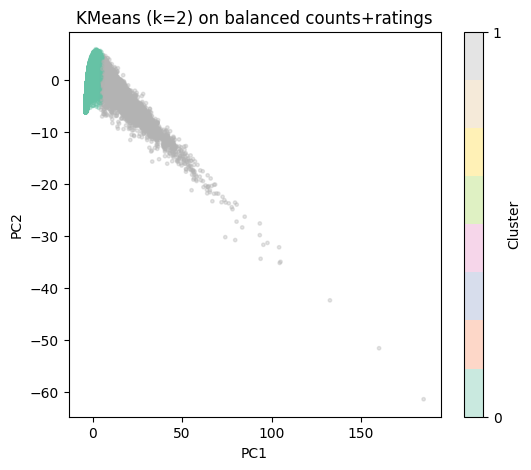

In [33]:
plt.figure(figsize=(6,5))
plt.scatter(XY[:,0], XY[:,1], c=labels, cmap="Set2", s=6, alpha=0.35, rasterized=True)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("KMeans (k=2) on balanced counts+ratings")
cbar = plt.colorbar(ticks=[0,1]); cbar.set_label("Cluster"); cbar.ax.set_yticklabels(["0","1"])
plt.show()


In [34]:
user_df['cnt_Drama'].describe()

count    265848.000000
mean         24.796718
std          44.017105
min           0.000000
25%           4.000000
50%          10.000000
75%          27.000000
max        1815.000000
Name: cnt_Drama, dtype: float64